# Anime Analysis by Ben Osborn and OsbornAI

## This project consists of the scraping and creation of a dataset containing information about all anime's listed on MyAnimeList. This data is analysed, and a model is created to predict the anime's rating based on the pages features

### Scraping and dataset creation

#### Parses through the labels and the lists from the soup elements

In [1]:
from bs4 import BeautifulSoup

def parseList(element): # Have to check that a tags exist for ever single page and developer
    ret_list = [a.text for a in element.find_all('a')]
    
    return ", ".join(ret_list)

def parseLabel(element):
    string = element.text
    
    split_colens = string.split(':')
    removed_label = split_colens[1:]
    
    for i, label in enumerate(removed_label):
        removed_label[i] = label.replace('\n', '').strip()
    
    joined = " ".join(removed_label)
    
    return joined

#### These are the names of the raw initial columns in the dataframe

In [2]:
field_names = ['name_english', 'name_japanese', 'show_type', 'episodes', 'status', 'aired', 'broadcast_time', 'producers', 
               'licensors', 'studios', 'source', 'genres', 'episode_length', 'rating', 'score_and_scorers', 
               'members', 'favorites', 'description']

#### Scrapes the page from the show and returns a row of data for the dataframe

In [3]:
import requests

def createRow(url):
    ret_dict = {field_name: '' for field_name in field_names}

    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')

    side_panel = soup.find('td', class_='borderClass')
    side_panel_subdiv = side_panel.find('div')
    side_panel_divs = side_panel_subdiv.find_all('div')

    try:
        ret_dict['description'] = soup.find('p', itemprop='description').text

    except Exception as e:
        print(f"Encountered an error '{e}' for description at '{url}'.")

    for panel in side_panel_divs:
        try:
            split = str(panel.text.split(':')[0].strip())

            if split == "English":
                ret_dict['name_english'] = parseLabel(panel)

            if split == "Japanese":
                ret_dict['name_japanese'] = parseLabel(panel)

            if split == "Type":
                ret_dict['show_type'] = parseLabel(panel)

            if split == "Episodes":
                ret_dict['episodes'] = parseLabel(panel)

            if split == "Status":
                ret_dict['status'] = parseLabel(panel)

            if split == "Aired":
                ret_dict['aired'] = parseLabel(panel)

            if split == "Broadcast":
                ret_dict['broadcast_time'] = parseLabel(panel)

            if split == "Producers":
                ret_dict['producers'] = parseList(panel)

            if split == "Licensors":
                ret_dict['licensors'] = parseList(panel)

            if split == "Studios":
                ret_dict['studios'] = parseList(panel)

            if split == "Source":
                ret_dict['source'] = parseLabel(panel)

            if split == "Genres":
                ret_dict['genres'] = parseList(panel)

            if split == "Duration":
                ret_dict['episode_length'] = parseLabel(panel)

            if split == "Rating":
                ret_dict['rating'] = parseLabel(panel).split(' ')[0]

            if split == "Score":
                ret_dict['score_and_scorers'] = ", ".join([part.text for part in panel.find_all('span')][1:])

            if split == "Members":
                ret_dict['members'] = "".join(parseLabel(panel).split(','))

            if split == "Favorites":
                ret_dict['favorites'] = "".join(parseLabel(panel).split(','))

        except Exception as e:
            print(f"Encountered an error '{e}' at '{url}'.")
            
    return ret_dict
    
# createRow("https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood")

#### Go through the amount of pages specified then scrape the information for each show, then store them to a CSV file

In [4]:
# Introduce sharding of CSV to this
import os
from csv import DictWriter
import time

# Change the file saving location for this
def genDataset(end_page, csv_dir, csv_filename, start_page=0): # Where resume is the page of which it left off from
    link = 'Unknown'
            
    for i in range(start_page, end_page):
        
        print(f"Scraping page {i}...")

        csv_path = os.path.join(csv_dir, f'{csv_filename}-{i}.csv')

        with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = DictWriter(csvfile, fieldnames=field_names)
            
            writer.writeheader()

            url_page = f"https://myanimelist.net/topanime.php?limit={i*50}"
            req_list = requests.get(url_page)
            soup_list = BeautifulSoup(req_list.content, 'html.parser')
            shows = soup_list.find_all('tr', class_='ranking-list')

            for show in shows:
                try:
                    link = show.find('a').get('href')
                    data_row = createRow(link)
                    writer.writerow(data_row)

                    time.sleep(2) # These are required to stop the website from blocking us

                except Exception as e:
                    print(f"Encountered error '{e}' at '{link}'.")
                    
                    time.sleep(2)
    
    print("Dataset creation complete!")
    
csv_dir = os.path.join(os.getcwd(), 'csv')
# genDataset(300, csv_dir, 'mal-data-20-11-2020', start_page=0)

### Data handling and cleaning

#### Concatenate CSV files and put them into a data frame

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

csv_path = os.path.join(os.getcwd(), 'csv')

dfs = []
for csv in os.listdir(csv_path):
    dfs.append(pd.read_csv(os.path.join(csv_path, csv), index_col=0))

df = pd.concat(dfs)

#### Type conversion and data cleanup

In [6]:
df = df[df['episodes'] != 'Unknown']
df['episodes'] = df['episodes'].astype(int)

df['favorites'] = df['favorites'].astype(int)

df['members'] = df['members'].astype(int)

df = df.dropna()

In [7]:
def parseScoreAndScorer(score_and_scorers_raw, position):
    try:
        numerical_version = float(score_and_scorers_raw.split(', ')[position].strip())
        return numerical_version
    except:
        return pd.NaT
    
df['score'] = df['score_and_scorers'].apply(lambda s: parseScoreAndScorer(s, 0)).astype(float)
df['scorer'] = df['score_and_scorers'].apply(lambda s: parseScoreAndScorer(s, 1)).astype(int)
df = df.dropna()
df = df.drop('score_and_scorers', axis=1)

#### Time data parsing

In [8]:
def broadcastParse(broadcast_raw): # This parses through the broadcast time
    broadcast_split = [bc_time.strip() for bc_time in broadcast_raw.split(' at ')]
    if (len(broadcast_split) == 1) or ('Unknown' in broadcast_split):
        return pd.NaT
    broadcast_split[0] = broadcast_split[0][:-1]
    broadcast_split[1] = broadcast_split[1][:5]
    broadcast_string = " ".join(broadcast_split)
    
    return broadcast_string

df['broadcast_time'] = df['broadcast_time'].apply(broadcastParse)
df = df.dropna()
df['broadcast_time'] = pd.to_datetime(df['broadcast_time'], format='%A %H %M')

In [9]:
# This one needs to parse the minutes/hours for the episode length
def timeParse(time_raw):
    time_split = time_raw.split(' ')
    if time_split[1] == 'min.':
        return int(time_split[0])
    elif time_split[1] == 'hr.':
        if time_split[3] == 'min.':
            return int(time_split[0]) * 60 + int(time_split[2])
        else:
            return int(time_split[0]) * 60 # This will make sure that if there is only an hour it will not break
    else:
        return pd.NaT
    
df['episode_length'] = df['episode_length'].apply(timeParse)
df.dropna()

,name_japanese,show_type,episodes,status,aired,broadcast_time,producers,licensors,studios,source,genres,episode_length,rating,members,favorites,description,score,scorer
name_english,,,,,,,,,,,,,,,,,,
Fullmetal Alchemist Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",1900-01-01 17:00:00,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,"Action, Military, Adventure, Comedy, Drama, Ma...",24,R,2035061,168400,"""In order for something to be obtained, someth...",9.22,1238537
Steins;Gate,STEINS;GATE,TV,24,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",1900-01-01 02:05:00,"Frontier Works, Media Factory, Movic, AT-X, Ka...",Funimation,White Fox,Visual novel,"Thriller, Sci-Fi",24,PG-13,1643043,140395,The self-proclaimed mad scientist Rintarou Oka...,9.12,888306
Gintama Season 4,銀魂°,TV,51,Finished Airing,"Apr 8, 2015 to Mar 30, 2016",1900-01-01 18:00:00,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,"Action, Comedy, Historical, Parody, Samurai, S...",24,PG-13,365696,10417,"Gintoki, Shinpachi, and Kagura return as the f...",9.11,127501
Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,Finished Airing,"Oct 2, 2011 to Sep 24, 2014",1900-01-01 10:55:00,"VAP, Nippon Television Network, Shueisha",Viz Media,Madhouse,Manga,"Action, Adventure, Fantasy, Shounen, Super Power",23,PG-13,1469739,131325,Hunter x Hunter is set in a world where Hunter...,9.11,834570
Gintama Season 2,銀魂',TV,51,Finished Airing,"Apr 4, 2011 to Mar 26, 2012",1900-01-01 18:00:00,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",add some,Sunrise,Manga,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",24,PG-13,338508,6034,"After a one-year hiatus, Shinpachi Shimura ret...",9.08,141097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Project Blue Earth SOS,Project BLUE 地球SOS,TV,6,Finished Airing,"Jul 2, 2006 to Dec 3, 2006",1900-01-01 23:00:00,add some,"ADV Films, Funimation",A.C.G.T.,Unknown,"Sci-Fi, Adventure, Comedy, Shounen",45,PG-13,2870,5,In this exhilarating series paying homage to c...,6.68,873
NaN,ストラトス・フォー,TV,13,Finished Airing,"Jan 5, 2003 to Mar 30, 2003",1900-01-01 00:30:00,Bandai Visual,Bandai Entertainment,Studio Fantasia,Original,"Comedy, Military, Sci-Fi, Shounen",23,PG-13,9560,27,The Earth has developed a defense system again...,6.67,3705
Angel's 3Piece!,天使の3P！〈スリーピース〉,TV,12,Finished Airing,"Jul 10, 2017 to Sep 25, 2017",1900-01-01 20:00:00,"Sotsu, Lantis, AT-X, Barnum Studio, KlockWorx,...",Discotek Media,Project No.9,Light novel,"Music, School, Slice of Life",23,PG-13,47953,75,"Since entering high school, Kyou Nukui has not...",6.67,16646


In [10]:
def parseAired(aired_raw, position):
    aired_split = aired_raw.split(' to ')
    try:
        aired_parsed = " ".join(aired_split[position].strip().split(", "))
        aired_formatted = str(time.strftime('%d %m %Y', time.strptime(aired_parsed, '%b %d %Y')))
        return aired_formatted
    except:
        return pd.NaT

df['aired_start'] = pd.to_datetime(df['aired'].apply(lambda s: parseAired(s, 0)), format='%d %m %Y')
df['aired_end'] = pd.to_datetime(df['aired'].apply(lambda s: parseAired(s, 1)), format='%d %m %Y')
df = df.drop('aired', axis=1)
df = df.dropna()

### Data analysis

#### Question 1: What is the highest rated show in consideration with the amount of users?

In [11]:
# To solve this we say the rating is the probability of an anime being good, then we take the Z-scores 
# and we look at the highest Z-score which means it will be the anime that exceeds the average 
# chance of it being good based on its members
good_probability = df['score'].mean() / 10
probabilities = df['score'] / 10
stds = (good_probability * (1 - good_probability) / df['members']) ** 0.5
weighted_rating = (probabilities - good_probability) / stds

weighted_rating.sort_values(ascending=False)

name_english
Fullmetal Alchemist Brotherhood    692.685416
Steins;Gate                        594.449041
Hunter x Hunter                    559.581280
Death Note                         542.964682
One Punch Man                      485.689558
                                      ...    
NaN                               -143.503264
NaN                               -144.930863
King's Game                       -176.849661
School Days                       -193.818753
Pupa                              -291.695908
Length: 2196, dtype: float64

##### The best anime with the highest score based on its users is Fullmetal Alchemist as it has the highest Z-score above the mean rating based on it's users compared to the others

#### Question 2: What is the most popular genre on average?

<AxesSubplot:xlabel='genres'>

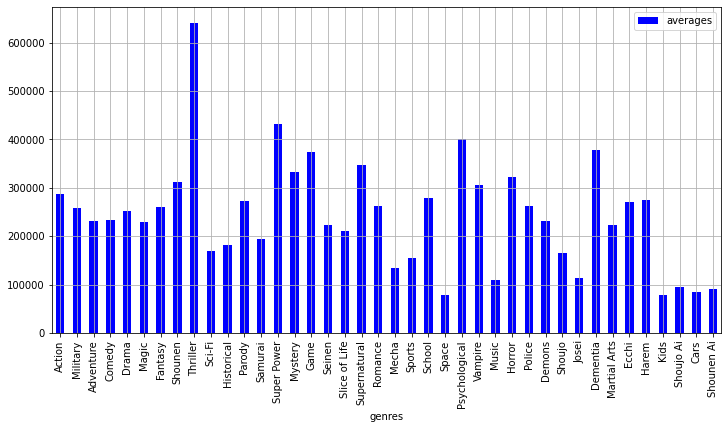

In [88]:
# To do this we are going to have to gather all of the different genre's and then make a new dataframe with these genres
# and then look at the one with the highest memberbase
df = df[df['producers'] != 'add some']
df = df[df['licensors'] != 'add some']
df = df[df['genres'] != 'add some']

genres = []
def makeDataList(array_string, data_list):
    split_string = array_string.split(", ")
    for item in split_string:
        if item not in data_list:
            data_list.append(item)

df['genres'].apply(lambda s: makeDataList(s, genres))

genre_df = pd.DataFrame()

averages = []
for genre in genres:
    dummy_df = df[df['genres'].str.contains(genre)]
    average_members = dummy_df['members'].mean()
    averages.append(average_members)

genre_df['genres'] = genres
genre_df['averages'] = averages

genre_df.plot.bar(x='genres', y='averages', grid=True, color='blue')

##### The most popular genre on average was police, followed by mecha and then super power

#### Question 3: What is the best month of the to launch a show for the most viewers?

<AxesSubplot:xlabel='aired_month'>

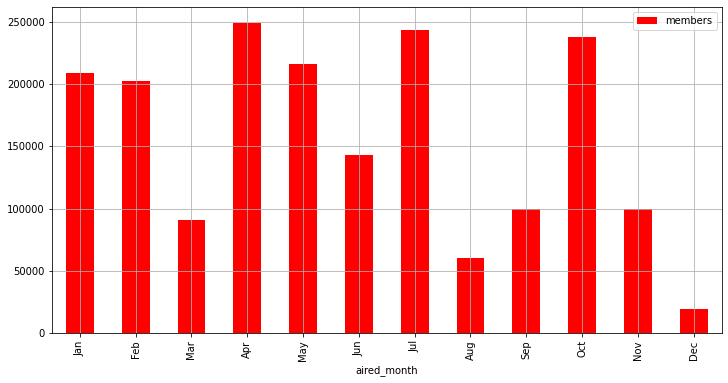

In [84]:
# Make seperate columns of the hour and then group by the hour under the average
viewers_df = df.copy()
viewers_df['aired_month'] = viewers_df['aired_start'].dt.month # Sort this dataframe by the column

viewers_df = viewers_df.groupby('aired_month').mean()
viewers_df.index = pd.to_datetime(viewers_df.index, format='%m').month_name().str[:3]
viewers_df = viewers_df.drop(['episodes', 'favorites', 'score', 'scorer'], axis=1)

viewers_df.plot.bar(grid=True, color='red')

##### The most successful anime's with the largest amount of watchers on average were released in April, followed by May, meaning these are the best times to put out an anime for the most amount of watches

#### Question 4: What was the best time to broadcast

<AxesSubplot:xlabel='broadcast_hour'>

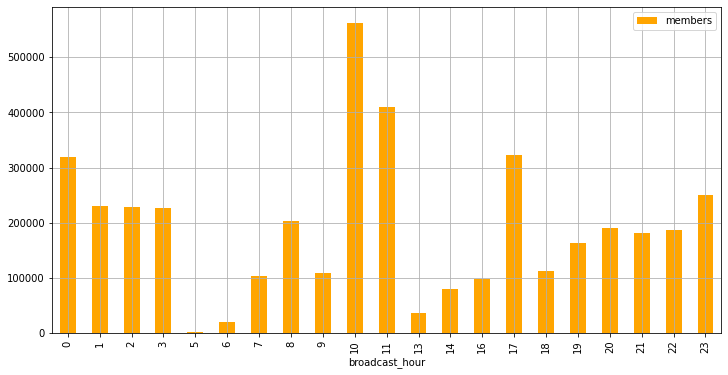

In [83]:
# We want to make a seperate column for the broadcast time in terms of its hour during the day
bc_df = df.copy()
bc_df['broadcast_hour'] = bc_df['broadcast_time'].dt.hour
bc_df = bc_df.groupby('broadcast_hour').mean()
bc_df = bc_df.drop(['episodes', 'favorites', 'score', 'scorer'], axis=1)

bc_df.plot.bar(grid=True, color='orange')

##### The shows with the highest amount of watchers were released around 10:00AM, therefore the best time to release a show to maximize viewers is at 10:00AM

#### Question 5: What studios have the best ratings with consideration for the amount of users?

In [82]:
# Use the standard deviation except this time use the data from the other Z-Scores to find where the studios are the best
# Using the same parsing function defined in the popular genre

studios = []
df['studios'].apply(lambda s: makeDataList(s, studios))

studio_df = pd.DataFrame()

average_ratings = []
average_members = []
for studio in studios:
    dummy_df = df[df['studios'].str.contains(studio)]
    rating_average = dummy_df['score'].mean()
    member_average = dummy_df['members'].mean()
    average_ratings.append(rating_average)
    average_members.append(member_average)

studio_df['studios'] = studios
studio_df['average_ratings'] = average_ratings
studio_df['average_members'] = average_members

good_probability = studio_df['average_ratings'].mean() / 10
probabilities = studio_df['average_ratings'] / 10
stds = (good_probability * (1 - good_probability) / studio_df['average_members']) ** 0.5
studio_df['weighted_rating'] = (probabilities - good_probability) / stds

best_scored_studios = studio_df.sort_values(ascending=False, by='weighted_rating').iloc[:, 0]
print(f"The studio with the best average ratings based on the amount of members is {best_scored_studios.iloc[0]}.\n")
print(f"Studios rated from best ratings to worst ratings:\n{best_scored_studios}")

The studio with the best average ratings based on the amount of members is Wit Studio.

Studios rated from best ratings to worst ratings:
4                               Wit Studio
7                          Kyoto Animation
69                   Hoods Drifters Studio
113                                  Shuka
1                                White Fox
                      ...                 
48                               GEEK TOYS
141    Children's Playground Entertainment
47                                   Seven
107                            EMT Squared
133                    Seven Arcs Pictures
Name: studios, Length: 184, dtype: object


##### The studio with the highest average score across all of the scorers is Wit Studio, followed by Kyoto Animation. The studio with the lowest score acorss scoters is Seven Arcs Pictures.

#### Question 6: What licensors have the best ratings with consideration for the amount of users?

The licensor with the best ratings for it's amount of watchers is Pied Piper



Text(0.5, 1.0, 'Standard deviations above the mean score for licensors')

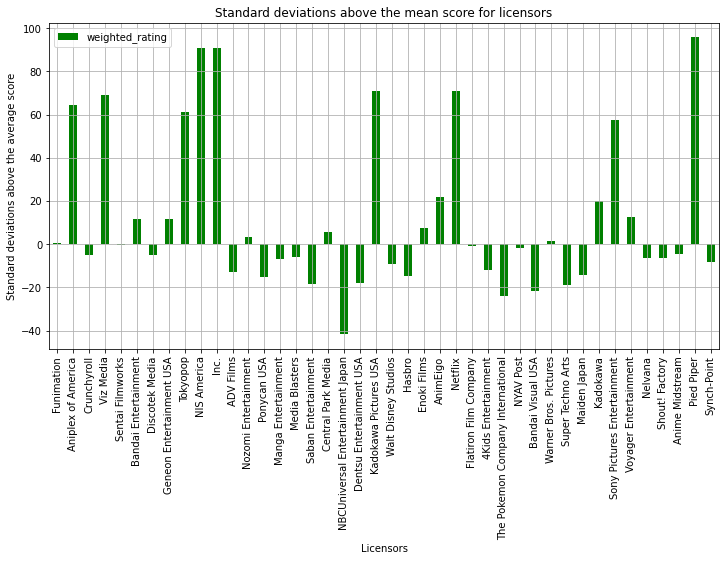

In [50]:
# Similar question to question 5, so we will answer it in a similar way

licensors = []
df['licensors'].apply(lambda s: makeDataList(s, licensors))

licensor_df = pd.DataFrame()

average_ratings = []
average_members = []
for licensor in licensors:
    dummy_df = df[df['licensors'].str.contains(licensor)]
    rating_average = dummy_df['score'].mean()
    member_average = dummy_df['members'].mean()
    average_ratings.append(rating_average)
    average_members.append(member_average)

licensor_df['licensors'] = licensors
licensor_df['average_ratings'] = average_ratings
licensor_df['average_members'] = average_members

good_probability = licensor_df['average_ratings'].mean() / 10
probabilities = licensor_df['average_ratings'] / 10
stds = (good_probability * (1 - good_probability) / licensor_df['average_members']) ** 0.5
licensor_df['weighted_rating'] = (probabilities - good_probability) / stds

print(f"The licensor with the best ratings for it's amount of watchers is {licensor_df.sort_values(by='weighted_rating', ascending=False).iloc[0, 0]}\n")
licensor_df.plot.bar(x='licensors', y='weighted_rating', grid=True, color='green')
plt.xlabel('Licensors')
plt.ylabel('Standard deviations above the average score')
plt.title('Standard deviations above the mean score for licensors')

##### The licensor with the most ratings considering the amount of scorers is Crunchyroll, and the licensor with the least is Netflix

### Data preprocessing for model

In [17]:
import string

def preprocessWord(word):
    new_word = word.lower()
    word_chars = [char for char in new_word if char in string.ascii_lowercase]
    
    return "".join(word_chars)
        
def preprocessText(description, studios, licensors, producers, genres):
    total = []
    
    studios_split = studios.split(',')
    for studio in studios_split:
        total.append(preprocessWord(studio))
        
    licensors_split = licensors.split(',')
    for licensor in licensors_split:
        total.append(preprocessWord(licensor))
    
    producers_split = producers.split(',')
    for producer in producers_split:
        total.append(preprocessWord(producer))
    
    genres_split = genres.split(',')
    for genre in genres_split:
        total.append(preprocessWord(genre))
    
    description_split = description.split(' ')
    for word in description_split:
        total.append(preprocessWord(word))
        
    return " ".join(total)

In [18]:
def createModelData(df):
    row_num = len(df.index)
    text_data = []
    score_data = []
    
    for i in range(row_num):
        row = df.iloc[i]
        description = row[14]
        studios = row[7]
        licensors = row[6]
        producers = row[5]
        genres = row[9]
        
        row_text = preprocessText(description, studios, licensors, producers, genres)
        score = row[15] / 10
        
        text_data.append(row_text)
        score_data.append(score)
        
    return text_data, score_data

text_data, score_data = createModelData(df)

In [19]:
# Now I need to make a word map and a counter of the word
from collections import Counter

words = " ".join([text for text in text_data]).split(' ')
counter = Counter(words)
most_common = counter.most_common()

word_map = {word: i+1 for i, (word, count) in enumerate(most_common)}

def sentenceToId(sentence, word_map):
    sentence_split = sentence.split(' ') # Here we assume that the sentence has been parsed properly
    encoded_sentence = [word_map[word] for word in sentence_split]
    
    return encoded_sentence

encoded_text = [sentenceToId(desc, word_map) for desc in text_data]

#### Remove outliers from the data

count    1266.000000
mean      147.486572
std        51.213235
min        10.000000
25%       110.000000
50%       156.000000
75%       183.750000
max       309.000000
dtype: float64


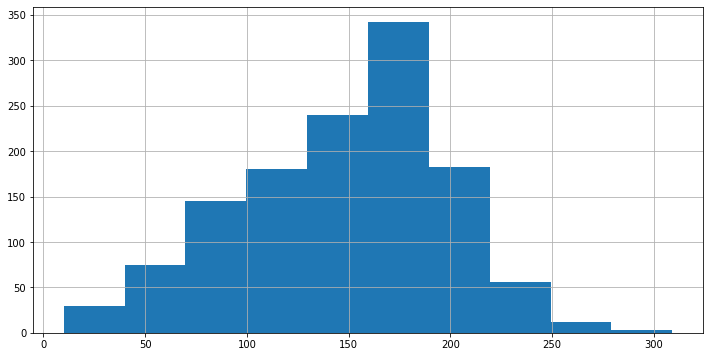

In [20]:
encoded_lens = [len(text) for text in encoded_text]
series = pd.Series(encoded_lens)

print(series.describe())
series.hist()

mean_raw = series.mean()
std_raw = series.std()

count    1265.000000
mean      147.358893
std        51.031520
min        10.000000
25%       110.000000
50%       156.000000
75%       183.000000
max       297.000000
dtype: float64


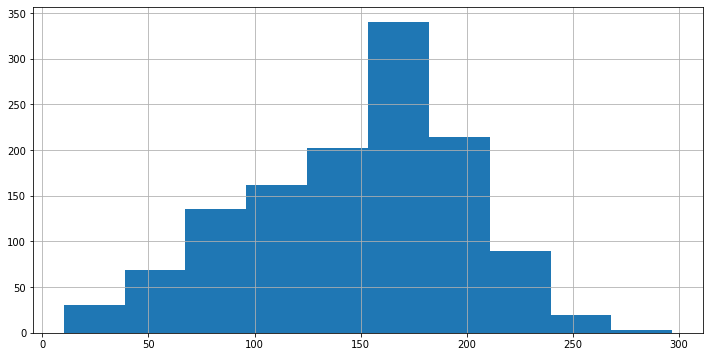

In [21]:
import numpy as np

encoded_text_cleaned = []
score_data_cleaned = []
for i, length in enumerate(encoded_lens):
    z_score = (length - mean_raw) / std_raw
    if (z_score > -3) and (z_score < 3):
        encoded_text_cleaned.append(encoded_text[i])
        score_data_cleaned.append(score_data[i])
        
encoded_lens_new = [len(text) for text in encoded_text_cleaned]
new_series = pd.Series(encoded_lens_new)

print(new_series.describe())
new_series.hist()

mean_text_length = int(np.round(new_series.mean()))

#### Padding and truncation of words for embedding layer

In [22]:
def correctSize(vector, vector_size):
    vec_len = len(vector)
    
    if vec_len == vector_size:
        return vector
    
    elif vec_len < vector_size:
        ret_vector = vector.copy()
        for _ in range(vector_size - vec_len):
            ret_vector.append(0)
    
    elif vec_len > vector_size:
        return vector[:vector_size]
    
padded_text = [correctSize(text, mean_text_length) for text in encoded_text_cleaned]

#### Split data into sets for the network

In [23]:
good_len = len(padded_text) - len(padded_text) % 10

fixed_padded_text = padded_text[:good_len]
fixed_score = score_data[:good_len]

train_len = int(0.8 * good_len)
val_len = int(0.1 * good_len)
test_len = int(0.1 * good_len)

train_text = np.array(fixed_padded_text[:train_len])
train_labels = np.array(fixed_score[:train_len])
train_data = (train_text, train_labels)

remaining_text = fixed_padded_text[train_len:]
remaining_labels = fixed_score[train_len:]

val_text = np.array(remaining_text[:val_len])
val_labels = np.array(remaining_labels[:val_len])
val_data = (val_text, val_labels)

test_text = np.array(remaining_text[test_len:])
test_labels = np.array(remaining_labels[test_len:])
test_data = (test_text, test_labels)

### Model building and testing

#### Model creation, training, loading and saving

In [24]:
import tensorflow as tf
import pickle

def createModel(word_map, mean_text_length):
    model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=len(word_map) + 1, output_dim=mean_text_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.4)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1), metrics='accuracy') # This means we dont need a dense layer...?
    
    return model

def trainModel(model, train_data, epochs, batch_size, validation_data):
    history = model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=validation_data)
    
    return history

def saveModel(model, save_dir):
    model_as_json = model.to_json()
    with open(os.path.join(save_dir, 'model.json'), 'w') as json_file:
        json_file.write(model_as_json)
    model.save_weights(os.path.join(save_dir, 'model.h5'))
    
    with open(os.path.join(save_dir, 'history.p'), 'wb') as pickle_file:
        pickle.dump(history, pickle_file)
    
    print(f"Saved model to {save_dir}")
    
def loadModel(load_dir):
    with open(os.path.join(load_dir, 'model.json'), 'r') as json_file:
        loaded_json_model = json_file.read()
    model = tf.keras.models.model_from_json(loaded_json_model)
    model.load_weights(os.path.join(load_dir, 'model.h5'))
    
    with open(os.path.join(load_dir, 'history.p'), 'rb') as pickle_file:
        history = pickle.load(pickle_file)
        
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1), metrics='accuracy')
    
    return model, history